## **Programa de Pós-Graduação em Computação - INF/UFRGS**
### Disciplina CMP263 - Aprendizagem de Máquina
#### *Profa. Mariana Recamonde-Mendoza (mrmendoza@inf.ufrgs.br)*
<br>

---
***Observação:*** *Este notebook é disponibilizado aos alunos como complemento às aulas síncronas e aos slides preparados pela professora. Desta forma, os principais conceitos são apresentados no material teórico fornecido. *


---


# Validação Cruzada e Overfitting/Underfitting

Este notebook tem como objetivo explicar:

1. O que é **validação cruzada k-fold**.
2. O que é **validação cruzada aninhada**.
3. Exemplos práticos de **underfitting** e **overfitting** com algoritmos simples de classificação.

Usaremos datasets artificiais e alguns algoritmos do `scikit-learn`: **KNN, Árvores de Decisão, Naive Bayes e SVM**.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_moons, make_classification
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score



## Dataset de Exemplo

Vamos usar um datasets simples do `sklearn`:

- **Moons**: útil para visualização em 2D.


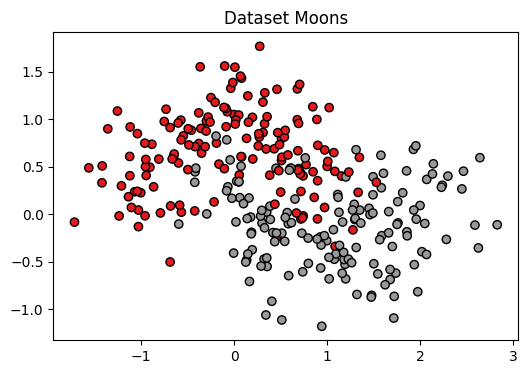

In [ ]:

X, y = make_moons(noise=0.3, random_state=42, n_samples=300)

plt.figure(figsize=(6,4))
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Set1, edgecolor='k')
plt.title("Dataset Moons")
plt.show()



## Underfitting e Overfitting

- **Underfitting**: modelo muito simples, não captura o padrão dos dados.
- **Overfitting**: modelo muito complexo, se ajusta demais aos dados de treino, mas generaliza mal.

Exemplo: **KNN** com diferentes valores de `k`.


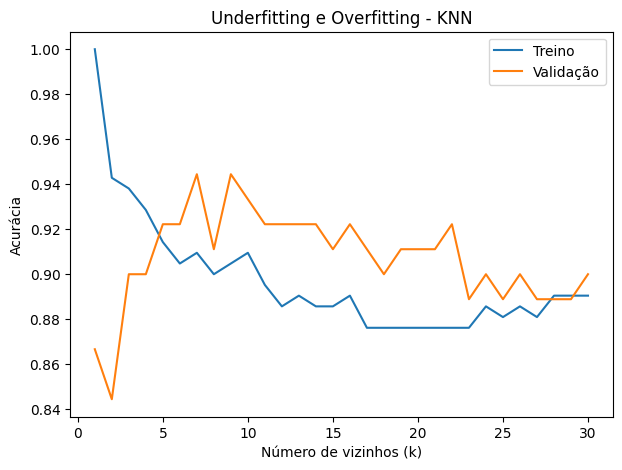

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Dataset
X, y = make_moons(n_samples=300, noise=0.3, random_state=42)

# Divisão treino/validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# ============================
# 1. Underfitting e Overfitting no KNN
# ============================

k_values = range(1, 31)
train_acc = []
val_acc = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    train_acc.append(model.score(X_train, y_train))
    val_acc.append(model.score(X_val, y_val))

plt.figure(figsize=(7,5))
plt.plot(k_values, train_acc, label="Treino")
plt.plot(k_values, val_acc, label="Validação")
plt.xlabel("Número de vizinhos (k)")
plt.ylabel("Acurácia")
plt.title("Underfitting e Overfitting - KNN")
plt.legend()
plt.show()


Exemplo: **Árvores de decisão** com diferentes valores de `profundidade máxima`.


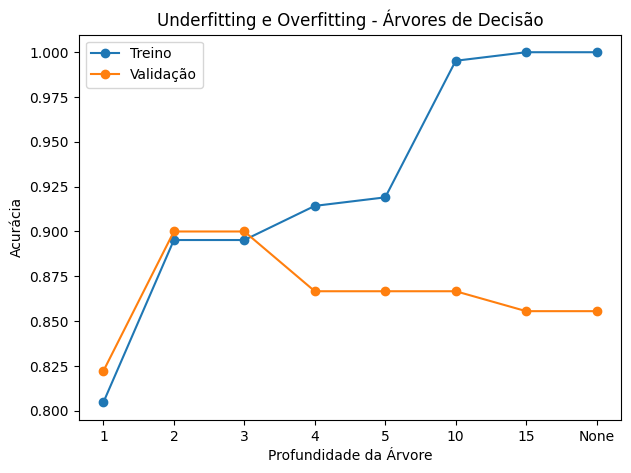

In [ ]:
# ============================
# 2. Underfitting e Overfitting em Árvores de Decisão
# ============================

depth_values = [1, 2, 3, 4, 5, 10, 15, None]  # None = árvore sem limite
train_acc = []
val_acc = []

for d in depth_values:
    model = DecisionTreeClassifier(max_depth=d, random_state=42)
    model.fit(X_train, y_train)
    train_acc.append(model.score(X_train, y_train))
    val_acc.append(model.score(X_val, y_val))

# Converter None em string para plotar
depth_labels = [str(d) for d in depth_values]

plt.figure(figsize=(7,5))
plt.plot(depth_labels, train_acc, marker="o", label="Treino")
plt.plot(depth_labels, val_acc, marker="o", label="Validação")
plt.xlabel("Profundidade da Árvore")
plt.ylabel("Acurácia")
plt.title("Underfitting e Overfitting - Árvores de Decisão")
plt.legend()
plt.show()


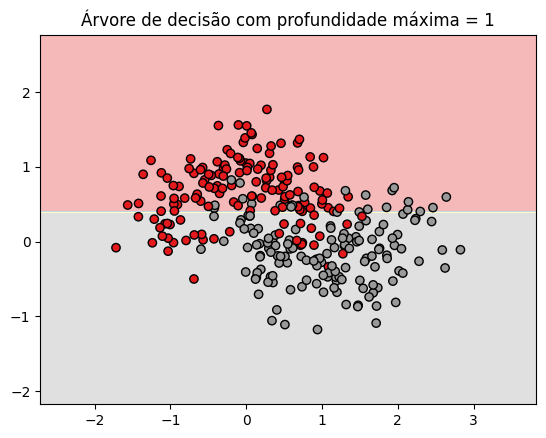

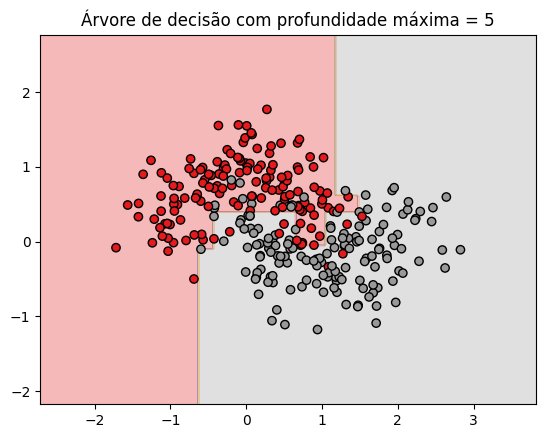

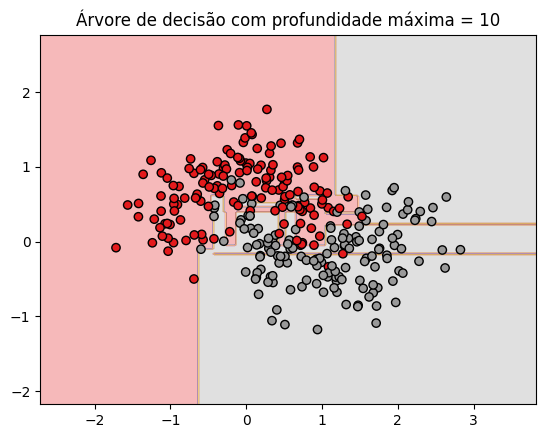

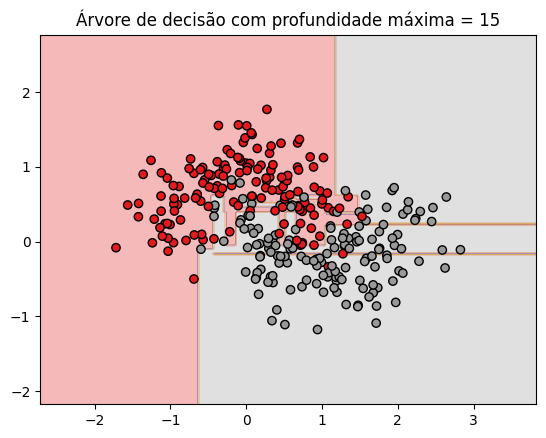

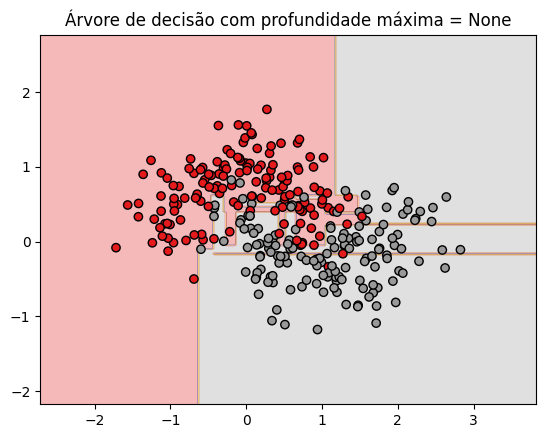

In [ ]:

def plot_dt(d):
    model =   DecisionTreeClassifier(max_depth=d, random_state=42)
    model.fit(X, y)

    # grade de pontos
    xx, yy = np.meshgrid(np.linspace(X[:,0].min()-1, X[:,0].max()+1, 200),
                         np.linspace(X[:,1].min()-1, X[:,1].max()+1, 200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Set1)
    plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Set1, edgecolor='k')
    plt.title(f"Árvore de decisão com profundidade máxima = {d}")
    plt.show()


depth_values = [1,  5, 10, 15, None]  # None = árvore sem limite
train_acc = []
val_acc = []

for d in depth_values:
    plot_dt(d)



## Validação Cruzada k-Fold

Divide o conjunto de dados em **k partes** (folds). Em cada rodada, uma parte é usada para teste e o restante para treino.
O resultado final é a média das métricas.

Exemplo com diferentes classificadores.


In [ ]:

X2, y2 = make_classification(n_samples=500, n_features=20, n_informative=15, random_state=42)

models = {
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC()
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    scores = cross_val_score(model, X2, y2, cv=kf)
    print(f"{name}: média={scores.mean():.3f}, desvio={scores.std():.3f}")


KNN: média=0.928, desvio=0.023
Decision Tree: média=0.752, desvio=0.017
Naive Bayes: média=0.848, desvio=0.044
SVM: média=0.932, desvio=0.027



## Validação Cruzada Aninhada

Serve para **seleção justa de hiperparâmetros** e avaliação do modelo.

Exemplo: selecionar `k` para o KNN usando `GridSearchCV` dentro de uma validação cruzada externa.


In [ ]:

param_grid = {"n_neighbors": [1, 3, 5, 10, 20]}
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, param_grid, cv=inner_cv)

nested_scores = cross_val_score(clf, X2, y2, cv=outer_cv)
print("Nested CV score (média):", nested_scores.mean())
print("Nested CV score (desvio):", nested_scores.std())


Nested CV score (média): 0.9099999999999999
Nested CV score (desvio): 0.026076809620810583



## Conclusões

- **Underfitting**: modelo muito simples → baixo desempenho.
- **Overfitting**: modelo muito complexo → ótimo no treino, ruim no teste.
- **Validação cruzada k-fold**: avaliação mais robusta do que treino/teste único.
- **Validação cruzada aninhada**: essencial para avaliar modelos com seleção de hiperparâmetros.

👉 Sempre separar bem treino, validação e teste para garantir avaliação justa!
